### Sample

In [2]:
  import csv
  import numpy as np
  
  with open("/home/rtlink/robros/dataset/robros_dataset/free_joint_1.csv", newline='') as csv_file:
    data = np.array(list(csv.reader(csv_file, delimiter=","))).astype("float")
    print(np.shape(data))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (100,) + inhomogeneous part.

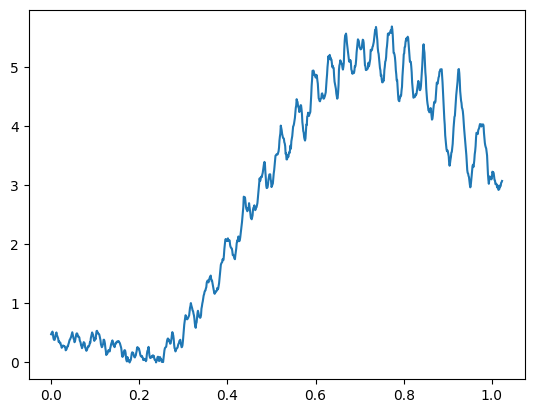

In [6]:
  import numpy as np
  import matplotlib.pyplot as plt
  
  t = np.arange(0, 0.001*np.shape(data)[1], 0.001)
  i = 10   # Select a signal piece
  plt.plot(t, data[i, :])
  plt.show()

## Prerequisites & Data Loader

이 부분은 Dataset 을 학습에 활용하기 위해 정제하는 기능을 담당합니다. <br>
데이터셋의 filename 규칙은 , "클래스_joint_조인트 넘버" 이기 때문에, 해당 이름에서 정보를 가져와 torch 의 DataLoader 에게 제공합니다. 
<br>
전체 데이터셋을 분할해 train 데이터셋과 test 데이터셋을 만듭니다. 

In [3]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split

import numpy as np

import os
import chardet

In [4]:
with open('/home/rtlink/robros/dataset/robros_dataset/free_joint_1.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))
    
print(result)

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}


In [5]:
file_path = '/home/rtlink/robros/dataset/robros_dataset/free_joint_1.csv' 
df = pd.read_csv(file_path)
df.columns = ['Data' for _ in df.columns]

df_head = df.head()
df_head

,Data,Data,Data,Data,Data,Data,Data,Data,Data,Data,...,Data,Data,Data,Data,Data,Data,Data,Data,Data,Data
0,-0.009232,-0.009501,-0.009774,-0.010053,-0.010337,-0.010627,-0.010924,-0.011228,-0.011538,-0.011855,...,0.641356,0.642515,0.643674,0.644834,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.009253,-0.009522,-0.009795,-0.010073,-0.010357,-0.010648,-0.010945,-0.011248,-0.011558,-0.011875,...,0.643477,0.644642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.009279,-0.009547,-0.009820,-0.010098,-0.010382,-0.010672,-0.010969,-0.011272,-0.011581,-0.011898,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.009575,-0.009847,-0.010124,-0.010407,-0.010694,-0.010988,-0.011289,-0.011596,-0.011910,-0.012230,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.009601,-0.009873,-0.010150,-0.010432,-0.010720,-0.011013,-0.011314,-0.011620,-0.011934,-0.012254,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
def interpolate_csv(file_path):
    data = pd.read_csv(file_path, header=None)
 
    max_length = max(data.apply(len, axis=1))
 
    interpolated_data = []
    for _, row in data.iterrows():
        x = np.arange(len(row))
        xp = np.linspace(0, len(row) - 1, max_length)
        interpolated_row = np.interp(xp, x, row)
        interpolated_data.append(interpolated_row)
 
    interpolated_df = pd.DataFrame(interpolated_data)
 
    return interpolated_df

def standardize_row_lengths(df, target_length=1000):
    standardized_data = []
 
    for _, row in df.iterrows():
        # NaN 값 제거 (선형 보간을 통해 채움)
        row = row.interpolate().fillna(method='bfill').fillna(method='ffill')
        current_length = len(row)
        if current_length < target_length:
            # 길이가 짧은 경우 interpolate
            x = np.linspace(0, current_length - 1, num=current_length)
            xp = np.linspace(0, current_length - 1, num=target_length)
            interpolated_row = np.interp(xp, x, row)
            standardized_data.append(interpolated_row)
        elif current_length > target_length:
            # 길이가 긴 경우 샘플링
            indices = np.linspace(0, current_length - 1, num=target_length, dtype=int)
            sampled_row = row.iloc[indices].values
            standardized_data.append(sampled_row)
        else:
            # 이미 길이가 1000인 경우
            standardized_data.append(row.values[:target_length])
 
    # 모든 행이 동일한 길이를 가지도록 DataFrame 생성
    standardized_df = pd.DataFrame(standardized_data, columns=range(target_length))
    return standardized_df
 

def find_nan_locations_file(file_path):
    data = pd.read_csv(file_path, header=None)
 
    nan_locations = []
    for row_index, row in data.iterrows():
        for col_index, value in row.items():
            if pd.isna(value):
                nan_locations.append((row_index, col_index))
 
    return len(nan_locations)

def find_nan_locations_df(df):
    # NaN 값이 있는 위치 찾기
    nan_locations = []
    for row_index, row in df.iterrows():
        for col_index, value in row.items():
            if pd.isna(value):
                nan_locations.append((row_index, col_index))
 
    return len(nan_locations)


In [23]:
# NaN 위치 찾기
nan_locations = find_nan_locations_file(file_path)
 
# 결과 출력
print("NaN 값이 있는 위치:", nan_locations)

NaN 값이 있는 위치: 14613


In [30]:
standardized_df = standardize_row_lengths(df)

standardized_df.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-0.009232,-0.009501,-0.009774,-0.010337,-0.010627,-0.010924,-0.011538,-0.011855,-0.012509,-0.012846,...,0.636727,0.637883,0.640198,0.641356,0.643674,0.644834,0.644834,0.644834,0.644834,0.644834
1,-0.009253,-0.009522,-0.009795,-0.010357,-0.010648,-0.010945,-0.011558,-0.011875,-0.012528,-0.012865,...,0.638821,0.639984,0.642312,0.643477,0.644642,0.644642,0.644642,0.644642,0.644642,0.644642
2,-0.009279,-0.009547,-0.009820,-0.010382,-0.010672,-0.010969,-0.011581,-0.011898,-0.012550,-0.012887,...,0.640642,0.641812,0.642983,0.642983,0.642983,0.642983,0.642983,0.642983,0.642983,0.642983
3,-0.009575,-0.009847,-0.010124,-0.010694,-0.010988,-0.011289,-0.011910,-0.012230,-0.012891,-0.013232,...,0.643176,0.643176,0.643176,0.643176,0.643176,0.643176,0.643176,0.643176,0.643176,0.643176
4,-0.009601,-0.009873,-0.010150,-0.010720,-0.011013,-0.011314,-0.011934,-0.012254,-0.012914,-0.013254,...,0.642258,0.642258,0.642258,0.642258,0.642258,0.642258,0.642258,0.642258,0.642258,0.642258


In [31]:
# NaN 위치 찾기
nan_locations = find_nan_locations_df(standardized_df)
 
# 결과 출력
print("NaN 값이 있는 위치:", nan_locations)

NaN 값이 있는 위치: 0


In [149]:
file_path = '../dataset/fre-joint-2.csv' 
df = pd.read_csv(file_path)

df_head = df.head()
df_head

,1.30163187206714,1.34227782906024,1.36601716698138,1.36540848434894,1.28186756790607,1.17605454147784,1.05906707466571,0.944797877678559,0.905153636345551,0.910450045475648,...,0.625276331314728,0.652426187405274,0.646736626038239,0.770377818951295,0.782884899983094,0.783286098847077,0.830185298332856,0.745180253395722,0.708126251110718,0.73016870439975
0,1.119524,1.139100,1.123053,1.121027,1.097130,1.051738,1.010435,0.963314,0.962116,0.972487,...,1.067153,1.159086,1.166204,1.175154,1.268520,1.284450,1.239401,1.219701,1.206682,1.223165
1,0.946032,0.946192,0.900455,0.875040,0.802903,0.704740,0.643124,0.623382,0.679666,0.790432,...,0.377264,0.366537,0.459590,0.475777,0.495566,0.467346,0.393654,0.395211,0.355034,0.328776
2,0.389996,0.462855,0.558888,0.646652,0.636034,0.605765,0.501819,0.378125,0.352187,0.398400,...,0.209720,0.165784,0.271551,0.375801,0.460011,0.547259,0.548530,0.487901,0.272585,0.002474
3,0.898607,0.901057,0.901415,0.892560,0.892396,0.906815,0.911645,0.895205,0.897894,0.900050,...,1.044256,1.024004,1.063011,1.125953,1.159884,1.221911,1.273289,1.217835,1.240803,1.180278
4,0.428559,0.507561,0.322221,0.217268,0.093255,0.164837,0.238633,0.515040,0.418316,0.590729,...,0.755519,0.706102,0.748771,0.662474,0.733623,0.648815,0.726053,0.661582,0.675890,0.716787


In [165]:
file_path = '../dataset/cls-joint-1.csv' 
df = pd.read_csv(file_path)

df_head = df.head()
df_head

,0.231078769555404,0.229507620921447,0.233483965983703,0.229218299975707,0.228612985005691,0.218610282531097,0.205247606625869,0.205917622437789,0.207369189253166,0.21645125328572,...,0.505354996314361,0.499195273509338,0.472134973397567,0.435439820876434,0.423999066939666,0.419865484824493,0.410384144177749,0.398412491669967,0.407250251164749,0.426174249043777
0,0.664851,0.601832,0.651157,0.655680,0.591174,0.640484,0.627837,0.590728,0.630789,0.643297,...,0.522785,0.492753,0.507904,0.499937,0.514909,0.526507,0.520162,0.510210,0.507163,0.535457
1,0.025861,0.004856,0.015854,0.004308,0.062601,0.140659,0.206508,0.227092,0.231525,0.268106,...,0.244397,0.268564,0.275718,0.300163,0.319668,0.332139,0.328882,0.340627,0.337326,0.322288
2,0.075622,0.081900,0.079728,0.083550,0.081771,0.086257,0.081058,0.083457,0.080691,0.081767,...,0.189418,0.189040,0.200281,0.208950,0.215194,0.223287,0.220221,0.217608,0.214772,0.210036
3,0.491766,0.526911,0.541471,0.551704,0.585189,0.572992,0.652181,0.728867,0.804674,0.782011,...,0.625847,0.543761,0.568885,0.545045,0.608105,0.653446,0.640809,0.698302,0.737331,0.681578
4,0.025818,0.043970,0.059831,0.075596,0.082582,0.119802,0.136299,0.133576,0.147107,0.148745,...,0.330754,0.326225,0.298962,0.286437,0.294233,0.293703,0.301553,0.302112,0.291296,0.291641


In [11]:
# NaN 위치 찾기
nan_locations = find_nan_locations(file_path)
 
# 결과 출력
print("NaN 값이 있는 위치:", nan_locations)

NaN 값이 있는 위치: [(1, 1377), (1, 1378), (1, 1379), (1, 1380), (1, 1381), (1, 1382), (2, 1375), (2, 1376), (2, 1377), (2, 1378), (2, 1379), (2, 1380), (2, 1381), (2, 1382), (3, 1372), (3, 1373), (3, 1374), (3, 1375), (3, 1376), (3, 1377), (3, 1378), (3, 1379), (3, 1380), (3, 1381), (3, 1382), (4, 1368), (4, 1369), (4, 1370), (4, 1371), (4, 1372), (4, 1373), (4, 1374), (4, 1375), (4, 1376), (4, 1377), (4, 1378), (4, 1379), (4, 1380), (4, 1381), (4, 1382), (5, 1366), (5, 1367), (5, 1368), (5, 1369), (5, 1370), (5, 1371), (5, 1372), (5, 1373), (5, 1374), (5, 1375), (5, 1376), (5, 1377), (5, 1378), (5, 1379), (5, 1380), (5, 1381), (5, 1382), (6, 1361), (6, 1362), (6, 1363), (6, 1364), (6, 1365), (6, 1366), (6, 1367), (6, 1368), (6, 1369), (6, 1370), (6, 1371), (6, 1372), (6, 1373), (6, 1374), (6, 1375), (6, 1376), (6, 1377), (6, 1378), (6, 1379), (6, 1380), (6, 1381), (6, 1382), (7, 1359), (7, 1360), (7, 1361), (7, 1362), (7, 1363), (7, 1364), (7, 1365), (7, 1366), (7, 1367), (7, 1368), (7, 13

In [153]:
folder_path = '../sample_dataset'
files = os.listdir(folder_path)

class_files = {'cls': [], 'ctc': [], 'fre': []}
for file in files:
    if 'cls' in file:
        class_files['cls'].append(file)
    elif 'ctc' in file:
        class_files['ctc'].append(file)
    elif 'fre' in file:
        class_files['fre'].append(file)


In [154]:
def extract_joint_from_filename(filename):
    parts = filename.split('-')
    if parts[1].startswith('joint'):
        joint_number = parts[2].split('.')[0]
        return joint_number
    return None

In [155]:
def load_and_combine_files(file_list, folder_path):
    combined_df = pd.DataFrame()
    for file in file_list:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        df.columns = ['Data' for _ in df.columns]
        
        joint_number = extract_joint_from_filename(file)
        df['joint_number'] = joint_number
        
        combined_df = pd.concat([combined_df, df], ignore_index=True)
    return combined_df

In [156]:
cls_data = load_and_combine_files(class_files['cls'], folder_path)

In [157]:
ctc_data = load_and_combine_files(class_files['ctc'], folder_path)

In [158]:
fre_data = load_and_combine_files(class_files['fre'], folder_path)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/rtlink/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [77]:
# Data Optimization to avoid "out of memory error"

def optimize_memory(df):
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
        elif df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
    return df

In [159]:
cls_data['label'] = 0  
ctc_data['label'] = 1  
fre_data['label'] = 2  

여기까지 NaN 없음...

In [60]:
cls_data_optimized = optimize_memory(cls_data)
ctc_data_optimized = optimize_memory(ctc_data)
fre_data_optimized = optimize_memory(fre_data)

In [61]:
combined_data = pd.concat([cls_data_optimized, ctc_data_optimized, fre_data_optimized], ignore_index=True)

In [143]:
combined_data = pd.concat([cls_data, ctc_data, fre_data], ignore_index=False, axis=1)

In [169]:
print(cls_data.shape)
print(ctc_data.shape)
print(fre_data.shape)

(6959, 1026)
(7582, 1026)
(14097, 1026)


In [170]:
combined_data = pd.concat(
    [cls_data.iloc[1:], ctc_data.iloc[1:], fre_data.iloc[1:]],
    ignore_index=True, axis=0
)

In [133]:
combined_data = combined_data.drop(combined_data.index[0])

In [151]:
def prepare_dataset(df):
    df['label'] = df['label'].astype(int)
    df['joint_number'] = df['joint_number'].astype(int)
    
    # 클래스 레이블과 조인트 위치 추출
    labels = df['label'].values
    joints = df['joint_number'].values

    signals = df.drop(['label', 'joint_number'], axis=1).values
    signals = signals.astype(float)  

    return torch.tensor(signals, dtype=torch.float32), torch.tensor(labels, dtype=torch.int32), torch.tensor(joints, dtype=torch.int32)

In [171]:
# NaN 값 확인하는 코드

# 원본 데이터에서 NaN 값 확인
nan_in_signals = combined_data.isna().any().any()
print("Signal 데이터에 NaN이 포함되어 있습니까?", nan_in_signals)


Signal 데이터에 NaN이 포함되어 있습니까? False


In [172]:
signals, labels, joints = prepare_dataset(combined_data)

In [173]:
# TensorDataset 생성
dataset = TensorDataset(signals, labels, joints)

# 데이터 로더
# train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [174]:
# Split train and test dataset

total_size = len(dataset)
train_size = int(total_size * 0.7) # adjust the value  
test_size = total_size - train_size


train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [175]:
# DataLoader 에서 주는 데이터 샘플

# DataLoader에서 첫 번째 배치 가져오기
first_batch = next(iter(train_loader))
signals, labels, joints = first_batch

# 배치에서 신호, 레이블, 조인트 위치의 모양과 일부 샘플 출력
print("신호 데이터 모양:", signals.shape)
print("레이블 데이터 모양:", labels.shape)
print("조인트 위치 데이터 모양:", joints.shape)

# 첫 번째 샘플 출력
print("\n첫 번째 신호 샘플:\n", signals[5])
print("첫 번째 레이블 샘플:", labels[5])
print("첫 번째 조인트 위치 샘플:", joints[5])


신호 데이터 모양: torch.Size([64, 1024])
레이블 데이터 모양: torch.Size([64])
조인트 위치 데이터 모양: torch.Size([64])

첫 번째 신호 샘플:
 tensor([0.3978, 0.4175, 0.4026,  ..., 4.1258, 4.0550, 4.0866])
첫 번째 레이블 샘플: tensor(1, dtype=torch.int32)
첫 번째 조인트 위치 샘플: tensor(1, dtype=torch.int32)


## Model Train

In [ ]:
import torch.nn.functional as F

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(7, 16, 3, 1) # 7개 조인트에 대한 입력 채널
        self.conv2 = nn.Conv1d(16, 32, 3, 1)
        self.fc1 = nn.Linear(32*252, 128)
        
        # 클래스 분류를 위한 출력
        self.fc_classification = nn.Linear(128,3) # 3개 클래스 출력
        
        # 강도 및 조인트 위치 예측을 위한 출력층
        # self.fc_intensity = nn.Linear(128,1)
        self.fc_joint = nn.Linear(128,1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.maxpool1d(x, 2) # 커널 사이즈 : 2
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        
        class_output = self.fc_classification(x)
        
        intensity_output = self.fc_intensity(x)
        joint_output = self.fc_joint(x)
        
        return class_output, intensity_output, joint_output
    
    def train(model, device, train_loader, optimizer, epoch):
        model.train()
        for batch_idx, (data, target_class, target_intensity, target_joint) in enumerate(train_loader):
            data, target_class = data.to(device), target_class.to(device)
            target_intensity, target_joint = target_intensity.to(device), target_joint.to(device)
            optimizer.zero_grad()
            class_output, intensity_output, joint_output = model(data)
            
            loss_class = F.cross_entropy(class_output, target_class) # class output loss function : Cross Entropy
            loss_intensity = F.mse_loss(intensity_output, target_intensity) # intensity loss : MSE
            
            loss = loss_class + loss_intensity
            # loss function 수정 필요
            
            loss.backward()
            optimizer.step()
            
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            
            
        
        
        